In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
def numerical_factor (df):
    df["7_Days_MA"]=df["close"].rolling(window=7).mean().shift(1).fillna(0)
    df["14_Days_MA"]=df["close"].rolling(window=14).mean().shift(1).fillna(0)
    df["21_Days_MA"]=df["close"].rolling(window=21).mean().shift(1).fillna(0)
    df["7_Days_SD"]=df["close"].rolling(window=7).std().shift(1).fillna(0)
    df["volume"] = df["volume"].shift(1)
    df["O-C"] = (df["open"] - df["close"]).shift(1)
    df["H-L"] = (df["high"] - df["low"]).shift(1)
    return df

In [5]:
def clean_data(filename):
    df = pd.read_csv(filename+".csv")
    df["date"] = pd.to_datetime(df["date"])
    df['volume'] = df['volume'].apply(lambda x: x  if pd.isnull(x) else (float(x[:-1])*1000 if x.find("M")!= -1 else float(x[:-1])))
    df = df.dropna()
    df = df.set_index(df["date"],drop=True)
    df = df.loc["2019-12-1":]
    df = numerical_factor(df)
    df = df.loc["2020-1-1":]
    df.drop(["open","high","low"], axis=1,inplace=True)
    df.drop("date",axis=1,inplace=True)
    df.to_csv(filename+"_clean.csv")

In [7]:
def stock_preprocess(filename):
    clean_data(filename)
    df = pd.read_csv(filename+"_clean.csv",index_col="date")
    df.index = pd.to_datetime(df.index)
    return df
gold_uk_clean = stock_preprocess("Gold_UK")
#gold_cn_clean = stock_preprocess("Gold_CN")

In [8]:
ZGCF_df = pd.read_csv("ZGCF_Gold.csv")
Reddit_df = pd.read_csv("Reddit_Gold.csv")
Hotcopper_df = pd.read_csv("HotCopper_Gold.csv")
MSE_df = pd.read_csv("MSE_Gold.csv")

In [9]:
def weighted_sum(var, wts):
    if np.sum(wts) > 0:
        return np.dot(var,wts)/np.sum(wts)
    else:
        return 0

def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    try:
        return np.average(var, weights=wts)
    except:
        return 0

def weighted_variance(var, wts):
    """Calculates the weighted variance"""
    return np.average((var - weighted_mean(var, wts))**2, weights=wts)

def weighted_skew(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**3, weights=wts) /
            weighted_variance(var, wts)**(1.5))

def weighted_kurtosis(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**4, weights=wts) /
            weighted_variance(var, wts)**(2))

In [10]:
def pd_weight_day_mean(s,df,colname,nday):
    val_for_col2 = df.loc[s.index, colname]
    day_with_data = nday - val_for_col2.eq(0).sum()
    return weighted_sum(s,val_for_col2)/nday*day_with_data

In [16]:
def comment_data_preprocess(comment_df,country,start="2020-1-1",end="2023-12-31"):
    comment_df["date"] = pd.to_datetime(comment_df['date']).dt.date
    comment_df["Scale_Sentiment"] = comment_df["Sentiment score"] * comment_df["Relatedness"]/100
    comment_df["score"] = pd.to_numeric(comment_df["score"],errors='coerce').fillna(1)
    comment_df["abs_score"] = comment_df["score"].abs()
    #remove 0 weight
    comment_df["score"].replace(0,1,inplace = True)

    weight_avg = comment_df.groupby("date").apply(lambda x: weighted_mean(x["Scale_Sentiment"],wts = x["score"])).to_frame(country+"_Avg")
    count = comment_df.groupby("date")["Sentiment score"].count().to_frame(country+"_Volume")
    heat = comment_df.groupby("date")["abs_score"].sum().to_frame(country+"_Heat")
    #weight_var = comment_df.groupby("date").apply(lambda x: weighted_variance(x["Scale_Sentiment"],wts = x["score"])).to_frame("Var")
    #weight_skew = comment_df.groupby("date").apply(lambda x: weighted_skew(x["Scale_Sentiment"],wts = x["score"])).to_frame("Skew")
    #weight_kurtosis = comment_df.groupby("date").apply(lambda x: weighted_kurtosis(x["Scale_Sentiment"],wts = x["score"])).to_frame("Kurtosis")
    
    #features = [weight_avg,weight_var,weight_skew,weight_kurtosis]
    features =[weight_avg,count,heat]

    comment_by_date = pd.DataFrame(index = comment_df["date"].unique())
    for item in features:
        comment_by_date = pd.merge(comment_by_date,item,left_index=True, right_index=True)
    #comment_by_date["Date"] = comment_by_date.index
    comment_by_date.index = pd.to_datetime(comment_by_date.index)

    # filling missing date
    start = start
    end = end
    new_dates = pd.date_range(start=start,end=end,freq='D')
    comment_by_date = comment_by_date.reindex(new_dates)
    comment_by_date = comment_by_date.rename_axis('date')
    comment_by_date.fillna(0,inplace=True)

    return comment_by_date

In [17]:
def comment_factor (df,country):
    df[country+"_5_Days_SS"]=df.rolling("5D")[country+"_Avg"].apply(pd_weight_day_mean,args=(df,country+"_Volume",5))
    df[country+"_5_Days_Vol"]=df[country+"_Volume"].rolling("5D").mean()
    df[country+"_5_Days_Heat"]=df[country+"_Heat"].rolling("5D").mean()

In [18]:
def comment_process(df,country):
    df_preprocess = comment_data_preprocess(df,country)
    comment_factor(df_preprocess,country)
    return df_preprocess

In [19]:
UK_comment = comment_process(MSE_df,"UK")
US_comment = comment_process(Reddit_df,"US")
CN_comment = comment_process(ZGCF_df,"CN")
AU_comment = comment_process(Hotcopper_df,"AU")

In [20]:
comment_full_df = pd.concat([UK_comment,US_comment,CN_comment,AU_comment], axis=1)
UK_df = pd.concat([gold_uk_clean,comment_full_df], axis=1,join="inner")
#CN_df = pd.concat([gold_cn_clean,comment_full_df], axis=1,join="inner")

In [39]:
full_df = UK_df
Y = full_df["close"]
X = full_df.drop(["close"],axis=1)
y_pred = []
training_size = 300
for i in range(training_size,X.shape[0]):
    # print(f"current at {i}")
    size = training_size
    X_train = X.iloc[i-size:i]
    y_train = Y.iloc[i-size:i]
    X_test = X.iloc[i:i+1]
    regr = MLPRegressor(random_state=1,hidden_layer_sizes = (100,), max_iter=1000).fit(X_train, y_train)
    y_pred.append(regr.predict(X_test)[0])

In [44]:
from sklearn.metrics import mean_squared_error
#adjusted_y = Y.iloc[300:Y.shape[0]]
adjusted_y = Y.iloc[training_size:]
adjusted_y = pd.Series(adjusted_y)
y_pred = np.array(y_pred)

# error
errors = y_pred - adjusted_y

outlier_indices = np.argsort(np.abs(errors))[-2:]

filtered_adjusted_y = np.delete(adjusted_y.values, outlier_indices)
filtered_y_pred = np.delete(y_pred, outlier_indices)
filtered_errors = np.delete(errors.values, outlier_indices)

filtered_indices = np.delete(adjusted_y.index.values, outlier_indices)

array(['2021-03-12T00:00:00.000000000', '2021-03-15T00:00:00.000000000',
       '2021-03-16T00:00:00.000000000', '2021-03-17T00:00:00.000000000',
       '2021-03-18T00:00:00.000000000', '2021-03-19T00:00:00.000000000',
       '2021-03-22T00:00:00.000000000', '2021-03-23T00:00:00.000000000',
       '2021-03-24T00:00:00.000000000', '2021-03-25T00:00:00.000000000',
       '2021-03-26T00:00:00.000000000', '2021-03-29T00:00:00.000000000',
       '2021-03-30T00:00:00.000000000', '2021-03-31T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2021-04-05T00:00:00.000000000',
       '2021-04-06T00:00:00.000000000', '2021-04-07T00:00:00.000000000',
       '2021-04-08T00:00:00.000000000', '2021-04-09T00:00:00.000000000',
       '2021-04-12T00:00:00.000000000', '2021-04-13T00:00:00.000000000',
       '2021-04-14T00:00:00.000000000', '2021-04-15T00:00:00.000000000',
       '2021-04-16T00:00:00.000000000', '2021-04-19T00:00:00.000000000',
       '2021-04-20T00:00:00.000000000', '2021-04-21

In [42]:
RMSE = np.sqrt(mean_squared_error(filtered_adjusted_y, filtered_y_pred))
MAPE = np.mean(np.abs((filtered_adjusted_y - filtered_y_pred) / filtered_adjusted_y)) * 100
MBE = np.mean(filtered_adjusted_y - filtered_y_pred)

print(f"RMSE: {RMSE}")
print(f"MAPE: {MAPE}%")
print(f"MBE: {MBE}")

RMSE: 36.50213079563281
MAPE: 1.3786068347828397%
MBE: 0.4005497849553957


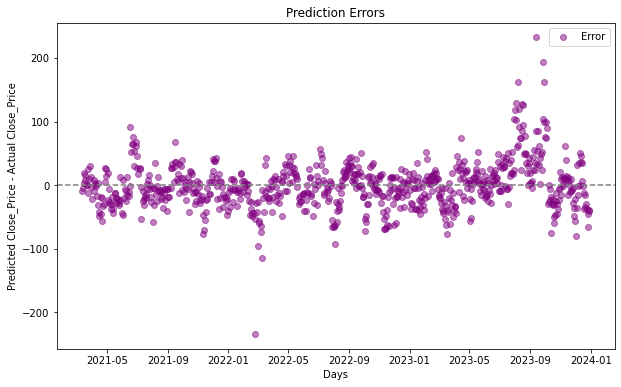

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(filtered_indices, filtered_errors, color='purple', label='Error', alpha=0.5)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Prediction Errors')
plt.xlabel('Days')
plt.ylabel('Predicted Close_Price - Actual Close_Price')
plt.legend()
plt.show()

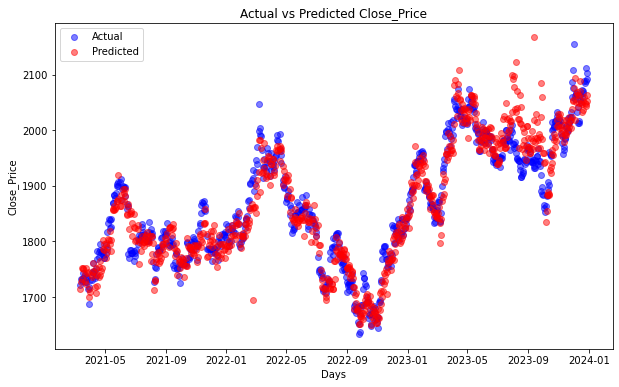

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(filtered_indices, filtered_adjusted_y, color='blue', label='Actual', alpha=0.5)
plt.scatter(filtered_indices, filtered_y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Close_Price')
plt.xlabel('Days')
plt.ylabel('Close_Price')
plt.legend()
plt.show()

In [48]:
# Model weight interpretive approach
import shap

def analyze_shap_values(regr, X_train, sample_index=0):
    # Create an interpreter
    explainer = shap.KernelExplainer(regr.predict, X_train)

    # Calculate the SHAP value of the entire training set
    shap_values = explainer.shap_values(X_train)

    shap.initjs()

    print(shap_values[sample_index])

    # Plot
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    plt.show()

    shap.summary_plot(shap_values, X_train)
    plt.show()

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

[  0.         -22.58024787 -41.57419875 -40.71754188   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           6.76987498   0.
  13.44529692]


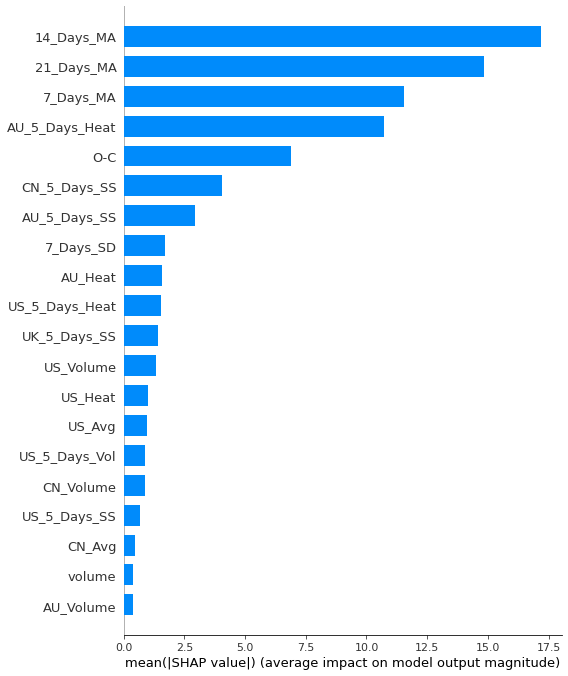

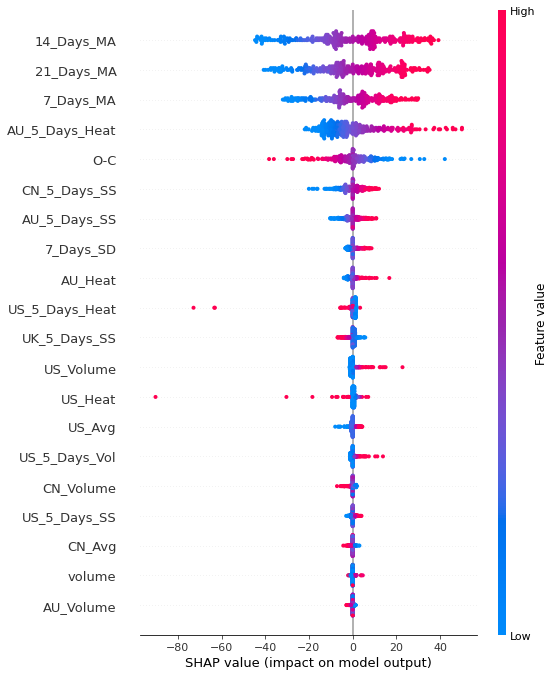

In [49]:
analyze_shap_values(regr, X_train, sample_index=0)